# Feature Selection and Model Training for Glucose Prediction

In this notebook, we will focus on feature selection and model training to predict clinically significant glucose swings in patients with type 1 diabetes. Our goal is to use the filtered data obtained from the exploratory data analysis (EDA) phase and develop a predictive model to assist in managing glucose levels more effectively.

The initial steps will involve loading the cleaned dataset, followed by a thorough examination of the features to determine which are most relevant for building our models. Based on our findings in the EDA notebook, we will incorporate temporal, demographic, and glucose variability features to construct a robust set of features.

After feature selection, we will proceed to model training, starting with a baseline linear regression model for benchmarking and then moving to more advanced time-sequenced models such as LSTM and GRU to capture the sequential nature of glucose readings and explore informer moldes for optimisation. Our goal is to enhance the predictive accuracy of our system to support better glycemic control in individuals using CGM systems.



In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [1]:
import pandas as pd

file_path = "/content/cleaned_glucose_tidepool_dataset_augmented.csv"
cleaned_data = pd.read_csv(file_path)

<ipython-input-1-0e64bd4889e5>:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv(file_path)


Lets take a look at our current data set


In [2]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+)
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+)
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+)
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+)
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+)


## Step 1: Feature Engineering for Glucose Prediction

 Based on the EDA recommendations and the hybrid model's requirements, we will create additional features:
 - Temporal features: Time of day, day of the week
 - Glucose variability metrics: Rolling average, rate of glucose change
 - Demographic features: Age, biological sex, age group
 - Flags for hypo/hyperglycemia based on specific glucose thresholds

In [5]:
# Step 1.1: Creating Temporal Features with a flexible datetime format
# Extract time of day (morning, afternoon, evening, night) and day of the week
def extract_time_features(df):
    # Convert 'time' to datetime format with flexible parsing to handle inconsistent formats
    df['time'] = pd.to_datetime(df['time'], errors='coerce', format='mixed')

    # Create feature for hour of the day
    df['hour_of_day'] = df['time'].dt.hour

    # Create time of day (morning, afternoon, evening, night)
    bins = [0, 6, 12, 18, 24]
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['time_of_day'] = pd.cut(df['hour_of_day'], bins=bins, labels=labels, right=False, include_lowest=True)

    # Create feature for day of the week
    df['day_of_week'] = df['time'].dt.dayofweek

    return df

# Re-apply time feature extraction
cleaned_data = extract_time_features(cleaned_data)


In [6]:
cleaned_data.head()


,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6


In [7]:
# Step 1.2: Creating Glucose Variability Features
# Calculate the rolling average and rate of change for glucose levels
def create_glucose_variability_features(df):
    # Calculate rolling average over a 1-hour window (assuming data every 5 mins, approx 12 readings)
    df['glucose_rolling_mean'] = df['value'].rolling(window=12).mean()

    # Calculate rate of glucose change (difference between consecutive readings)
    df['glucose_rate_of_change'] = df['value'].diff()

    return df

# Apply glucose variability feature engineering
cleaned_data = create_glucose_variability_features(cleaned_data)

In [8]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week,glucose_rolling_mean,glucose_rate_of_change
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,NaN
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203


In [10]:
import numpy as np
# Step 1.3: Flags for Hypo/Hyperglycemia
# Define thresholds for hypo and hyperglycemia (these values could be tuned later based on clinical, guidance @gary/@angel need input here )
HYPOGLYCEMIA_THRESHOLD = 3.9  # mmol/L
HYPERGLYCEMIA_THRESHOLD = 10.0  # mmol/L

def create_glucose_flags(df):
    # Create flag for hypoglycemia
    df['hypoglycemia_flag'] = np.where(df['value'] < HYPOGLYCEMIA_THRESHOLD, 1, 0)

    # Create flag for hyperglycemia
    df['hyperglycemia_flag'] = np.where(df['value'] > HYPERGLYCEMIA_THRESHOLD, 1, 0)

    return df

# Apply glucose flags feature engineering
cleaned_data = create_glucose_flags(cleaned_data)


In [11]:
cleaned_data.head()

,time,type,value,file_name,date,hour,ageStart,biologicalSex,age_group,hour_of_day,time_of_day,day_of_week,glucose_rolling_mean,glucose_rate_of_change,hypoglycemia_flag,hyperglycemia_flag
0,2019-06-23 00:04:58+00:00,cbg,8.60366,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,NaN,0,0
1,2019-06-23 00:09:59+00:00,cbg,8.38163,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203,0,0
2,2019-06-23 00:14:59+00:00,cbg,8.10409,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754,0,0
3,2019-06-23 00:19:59+00:00,cbg,7.82655,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.27754,0,0
4,2019-06-23 00:24:59+00:00,cbg,7.60452,train_39b32481640dc42af3ecdb07f8a3e5864d2e6d3e...,2019-06-23,0,64,Male,Seniors (56+),0,Night,6,NaN,-0.22203,0,0



## Step 2: Baseline Model Training and Splitting the Dataset

In this step, we will split the cleaned dataset into training and testing sets, which is an essential part of building a predictive model. By doing so, we ensure that we have separate data to evaluate how well our model generalizes to unseen examples.

We will begin by splitting the data into **training** (80%) and **testing** (20%) sets. The training set will be used to fit the model, and the testing set will be used to evaluate its performance.

After splitting the dataset, we will train a **simple linear regression model** as our baseline model. The linear regression model will help us establish a benchmark for evaluating future, more complex models. By comparing the performance of this baseline with the hybrid LSTM + Informer model, we can measure improvements in prediction accuracy and evaluate whether the complexity added by deep learning architectures is justified.

Let's start by splitting the dataset and training our baseline linear regression model.
"""

In [13]:
# Step 2.1: Splitting the Dataset
# We'll split the data into features (X) and target (y)
# For simplicity, we'll use 'value' (glucose reading) as the target variable
X = cleaned_data.drop(columns=['value', 'time', 'file_name', 'date'])  # Drop unnecessary columns and target
y = cleaned_data['value']  # Glucose reading as target

# Perform one-hot encoding on categorical columns to convert them into numeric values
X_encoded = pd.get_dummies(X, columns=['type', 'time_of_day', 'biologicalSex', 'age_group'], drop_first=True)

# Fill NaN values with the mean of their respective columns after encoding
X_encoded.fillna(X_encoded.mean(), inplace=True)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [14]:
# Step 2.2: Training a Baseline Linear Regression Model
# Initialize the linear regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Step 2.3: Evaluating the Baseline Model
# Make predictions on the testing set
y_pred = linear_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the performance metrics
print(f"Baseline Linear Regression Model Performance:\nMean Squared Error (MSE): {mse}\nR² Score: {r2}")

Baseline Linear Regression Model Performance:
Mean Squared Error (MSE): 0.7130762556103429
R² Score: 0.9224299210759238


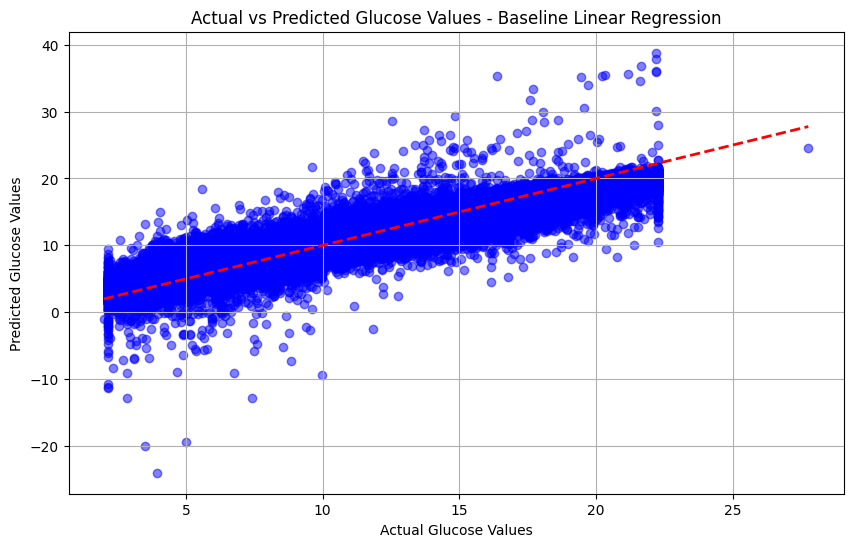

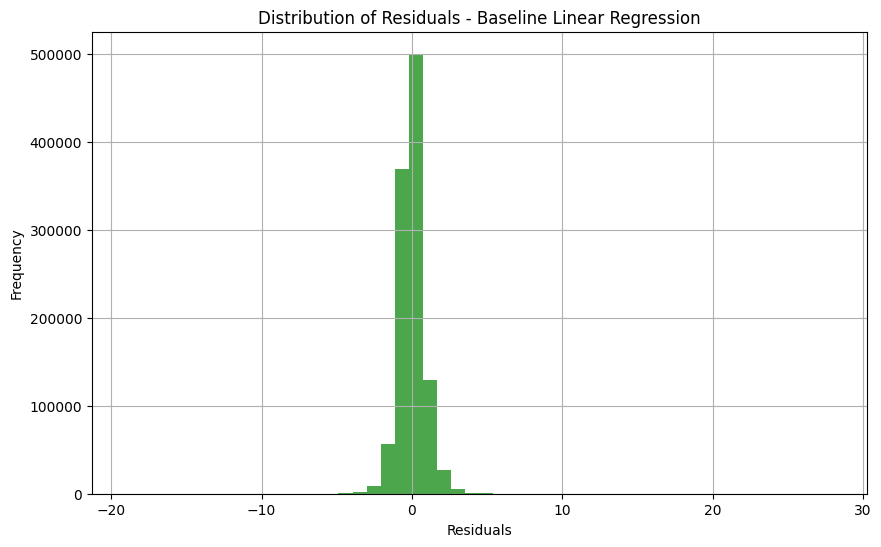

In [17]:
import matplotlib.pyplot as plt
# Plotting the predicted vs actual glucose values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Glucose Values')
plt.ylabel('Predicted Glucose Values')
plt.title('Actual vs Predicted Glucose Values - Baseline Linear Regression')
plt.grid(True)
plt.show()

# Plotting the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='g', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals - Baseline Linear Regression')
plt.grid(True)
plt.show()

### Looking at the base line


With an R² score of 0.922, the model explains approximately 92.2% of the variance in glucose values, which suggests that the model has reasonable explanatory power. However, given the scatter plot, this performance might be skewed by certain trends in the data and does not capture all nuances well.

**Scatter plot**

The model seems to underpredict for higher glucose values and overpredict for lower values, suggesting the linear model's limitations in capturing complex relationships.

The points are not tightly clustered around the line of perfect prediction, indicating that the model does not perform well across all glucose levels, particularly at the extremes.

**Risidual distribution**

The residuals are mostly centered around zero, which suggests that there is no major systematic bias (e.g., consistently overestimating or underestimating).
However, the spread of residuals is relatively wide, which means that the model has significant error in its predictions.
The residuals have some outliers on both ends, indicating that some glucose levels are poorly predicted.


The linear regression model provides a good initial benchmark, explaining much of the variance in glucose levels. However, the scatter plot and residuals indicate significant limitations in predicting extreme values and capturing complex non-linear trends.

The linear nature of the model is likely not sufficient to fully represent the underlying relationships in CGM data, which we understood would be the case since our data involves complex temporal patterns and non-linearities influenced by various physiological and lifestyle factors.

### Step 3: Defining the Hybrid LSTM + Informer Model

With the results of the baseline linear regression model above, we saw that while it performed reasonably well (with an R² score of 0.922), it struggled with capturing complex non-linear relationships and temporal patterns in glucose level data.

To address these limitations, we are now going to implement a hybrid model combining **LSTM (Long Short-Term Memory)** and **Informer Transformer**. This hybrid model is designed to better capture both short-term and long-term dependencies in the glucose data.

- **LSTM Component**: LSTMs are well-suited to time-series forecasting and can capture sequential dependencies effectively, especially for short- to medium-term time horizons.
- **Informer Component**: The Informer component will help improve long-term forecasting efficiency by reducing the computational complexity and providing more accurate long-range predictions.

By combining these two components, we aim to enhance the model's performance, particularly in predicting rapid glucose fluctuations and capturing complex dynamics.



 Perp for the the LSTM + Informer model, we need to structure the data into sequences. We will create sliding windows of data to use as input for the time-series model.


In [24]:
#  Data Normalization
# Normalize the features to a range between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
features = cleaned_data.drop(columns=['value', 'time', 'file_name', 'date'])  # Drop unnecessary columns
features_encoded = pd.get_dummies(features, columns=['type', 'time_of_day', 'biologicalSex', 'age_group'], drop_first=True)
features_normalized = scaler.fit_transform(features_encoded)

# Combine normalized features with the target glucose value
data_normalized = np.hstack((features_normalized, cleaned_data[['value']].values))


In [25]:
#  Creating Sliding Window Sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        target = data[i + seq_length, -1]  # Target is the glucose value
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 12  # Example sequence length (e.g., 1 hour of 5-minute intervals)
X, y = create_sequences(data_normalized, SEQ_LENGTH)

#  Convert Data to PyTorch Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [26]:
# Create DataLoader for Training and Testing
class GlucoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Split data into training and testing sets
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(GlucoseDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# first attempt using informer_encoder lib, not sucesfull
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
# 
# #  3.1: First we'll define the Hybrid LSTM + Informer Model
# class LSTMInformerModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, lstm_layers, output_dim):
#         super(LSTMInformerModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         # Informer component
#         # Informer Encoder
#         self.informer_encoder = InformerEncoder(
#             input_dim=hidden_dim,
#             d_model=512,
#             n_heads=8,
#             e_layers=3,
#             dropout=0.1
#         )

#         self.fc = nn.Linear(512, output_dim)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         informer_out = self.informer_encoder(lstm_out)
#         out = self.fc(informer_out[:, -1, :])
#         return out

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         out = self.fc(lstm_out[:, -1, :])
#         return out

Now that we've normalised the data and split it for our model we can move into the model development

In [ ]:
 # Still working on this section  as currently as the model runs but does not converge and takes too long to train
# Step 3.1: Implementing Informer Components
import torch.nn.functional as F

class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(ProbSparseAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.head_dim = d_model // n_heads
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        batch_size = q.size(0)
        q = self.query(q).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.key(k).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.value(v).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        # ProbSparse Attention mechanism (this is a simplifed version using matmul and softmax, anothr approach would be using dot https://community.deeplearning.ai/t/np-matmul-vs-np-dot/217450)
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_output = torch.matmul(attn_weights, v)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return attn_output


In [38]:
class InformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, e_layers, dropout):
        super(InformerEncoder, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout)
            for _ in range(e_layers)
        ])
        self.prob_sparse_attention = ProbSparseAttention(d_model, n_heads)
        self.input_proj = nn.Linear(input_dim, d_model)

    def forward(self, x):
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        attn_output = self.prob_sparse_attention(x, x, x)
        return attn_output


In [39]:
class LSTMInformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, output_dim):
        super(LSTMInformerModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True)

        # Informer Encoder
        self.informer_encoder = InformerEncoder(
            input_dim=hidden_dim,
            d_model=512,
            n_heads=8,
            e_layers=3,
            dropout=0.1
        )

        self.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        informer_out = self.informer_encoder(lstm_out)
        out = self.fc(informer_out[:, -1, :])
        return out

input_dim = X.shape[2]
hidden_dim = 128
lstm_layers = 2
output_dim = 1

model = LSTMInformerModel(input_dim, hidden_dim, lstm_layers, output_dim)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Step 3.2: Next we'll Initialize the Model, Loss Function, and Optimizer
input_dim = X.shape[2]
hidden_dim = 128
lstm_layers = 2
output_dim = 1

model = LSTMInformerModel(input_dim, hidden_dim, lstm_layers, output_dim)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 3.3: Training our Hybrid Model
def train_model(model, train_loader, loss_function, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

train_model(model, train_loader, loss_function, optimizer, epochs=10)


Epoch 1, Loss: nan
Epoch 2, Loss: nan
